In [ ]:
import gdown

train_file_id = "1pe4_HgXb9dctFGJXVNlyNcKSXZeht0lX&export=download&authuser=0&confirm=t&uuid=b95b4297-9c61-42f8-a501-4d62f585546c&at=AN_67v3oaLEb9cS4k8wNadaTebci%3A1729526518538"
download_url = "https://drive.google.com/uc?id={}".format(train_file_id)
gdown.download(download_url, quiet=False)

In [ ]:
validation_file_id = "1hwz6X-Zp7JpJL35K6P3z7k6O_PTXhUcT&export=download&authuser=0"
download_url = "https://drive.google.com/uc?id={}".format(validation_file_id)
gdown.download(download_url, quiet=False)

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


### 1.Preparing Train Dataset

In [2]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/car_img-test.zip', 'r') as file:
    file.extractall('train_dataset')

In [3]:
import os

train_folder = 'train_dataset/train/'
image_files = [f for f in os.listdir(train_folder) if f.endswith(('png', 'jpg', 'jpeg'))]

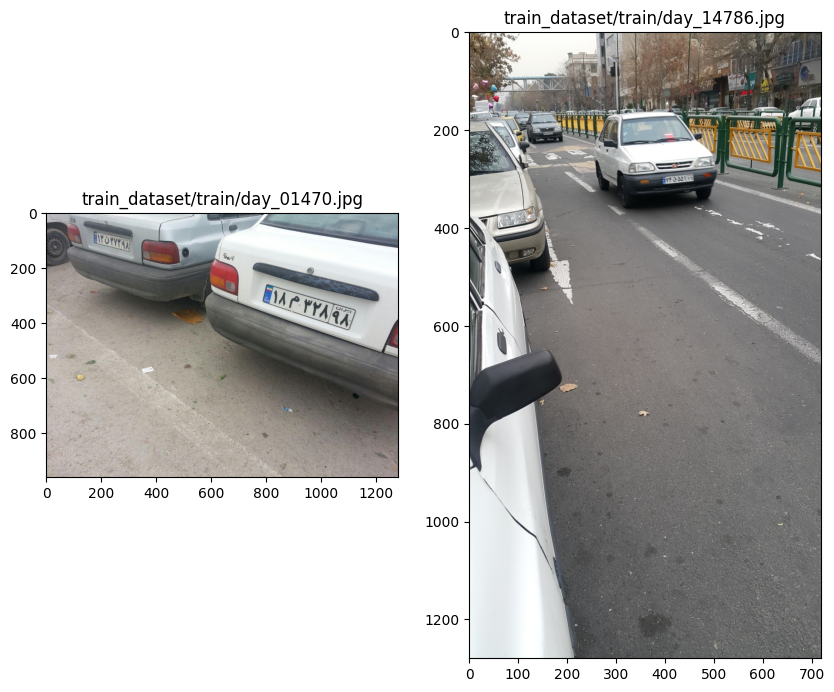

In [4]:
import os
from PIL import Image
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for i in range(2):
    path = os.path.join(train_folder, image_files[i])
    img = plt.imread(path)

    plt.subplot(1, 2, i + 1)
    plt.imshow(img)
    plt.title(path)

plt.show()

In [5]:
len(image_files)

4176

### Separate images taken in day

In [6]:
image_files = [t for t in image_files if t.startswith('day')]
len(image_files)

3351

### Separate Train Labels related to images in day

In [7]:
label_files = ['{}.xml'.format(t.split('.')[0]) for t in image_files]
len(label_files)

3351

In [17]:
from bs4 import BeautifulSoup


def calc_plate_area(plate_info):
    xmax = int(plate_info.find('xmax').text)
    xmin = int(plate_info.find('xmin').text)
    ymax = int(plate_info.find('ymax').text)
    ymin = int(plate_info.find('ymin').text)

    return (xmax - xmin) * (ymax - ymin)


def extract_plate_numbers(label_file):
    plate_char_num = 8

    file = open(label_file)
    content = file.read()
    bs_data = BeautifulSoup(content, 'xml')

    plate_numbers = list(filter(lambda tag: tag.text != 'کل ناحیه پلاک', bs_data.find_all('name')))
    plate_numbers = list(map(lambda tag: tag.text, plate_numbers))
    plate_numbers = [plate_numbers[i: i + plate_char_num] for i in range(0, len(plate_numbers), plate_char_num)]

    file.close()

    return plate_numbers


def extract_plate_coordinates(label_file):
    file = open(label_file)
    content = file.read()
    bs_data = BeautifulSoup(content, 'xml')

    matches = list(filter(lambda t: t.find('name').text == 'کل ناحیه پلاک', bs_data.find_all('object')))
    plate = max(matches, key = lambda p: calc_plate_area(p))
    plate = [int(plate.find('xmax').text), int(plate.find('xmin').text), int(plate.find('ymax').text), int(plate.find('ymin').text)]

    file.close()

    return plate

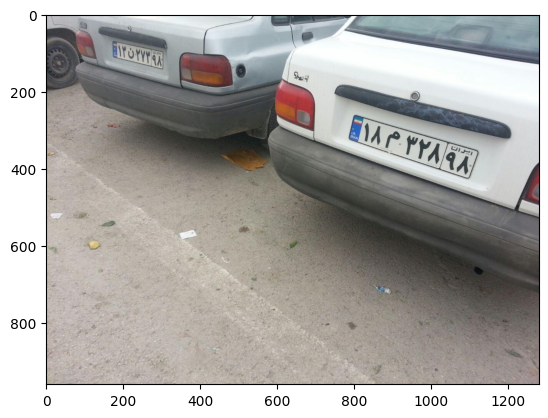

In [18]:
plt.imshow(plt.imread(train_folder + image_files[0]))

In [19]:
extract_plate_numbers(os.path.join(train_folder, label_files[0]))

[['1', '3', 'ن', '2', '7', '3', '9', '8'],
 ['1', '8', 'م', '3', '2', '8', '9', '8']]

In [20]:
extract_plate_coordinates(os.path.join(train_folder, label_files[0]))

[1123, 786, 430, 261]

### Converting all xml content to plate coordinates

In [21]:
train_labels = []

for i in range(len(label_files)):
    plate = extract_plate_coordinates(os.path.join(train_folder, label_files[i]))
    train_labels.append(plate)

### Normalizing data for adjusting brightness on train and validation data(in HSV dim)

In [ ]:
import cv2
import os

# Define folders
input_folder = '/content/train_dataset/test'
output_folder = '/content/train_dataset/normalizedImg'
os.makedirs(output_folder, exist_ok=True)

def normalize_hsv(img):
    # Convert to HSV color space
    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # Separate the HSV channels
    h, s, v = cv2.split(hsv_img)

    # Normalize the Value channel
    v = cv2.normalize(v, None, 0, 255, cv2.NORM_MINMAX)

    # Merge back the channels
    normalized_img = cv2.merge([h, s, v])

    # Convert back to RGB
    normalized_img = cv2.cvtColor(normalized_img, cv2.COLOR_HSV2RGB)

    return normalized_img

# Process and save each image
for filename in os.listdir(input_folder):
    if filename.endswith('.jpg'):
        img_path = os.path.join(input_folder, filename)

        # Load image and convert to RGB
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        # Normalize image
        img_normalized = normalize_hsv(img)

        # Convert back to uint8 for saving
        img_normalized = img_normalized.astype('uint8')

        # Save processed image
        output_path = os.path.join(output_folder, filename)
        cv2.imwrite(output_path, cv2.cvtColor(img_normalized, cv2.COLOR_RGB2BGR))

print("Images have been normalized and saved in the 'train_dataset/normalizedImg' folder.")



### Converting Images to (1280, 1280, 3)(batching method)

In [ ]:
#get the maximum width and height

from PIL import Image
import os

folder_path = 'train_dataset/train/'
max_width = 0
max_height = 0

for filename in os.listdir(folder_path):
    if filename.endswith('.jpg'):
        img_path = os.path.join(folder_path, filename)
        with Image.open(img_path) as img:
            width, height = img.size
            max_width = max(max_width, width)
            max_height = max(max_height, height)

print("Max width (x):", max_width)
print("Max height (y):", max_height)

### using batch on train data for preventing ram overflow

In [ ]:
import cv2
import os

# Define folders
input_folder = '/content/train_dataset/train'
output_folder = '/content/train_dataset/normalizedImg'
os.makedirs(output_folder, exist_ok=True)

def normalize_hsv(img):
    # Convert to HSV color space
    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # Separate the HSV channels
    h, s, v = cv2.split(hsv_img)

    # Normalize the Value channel
    v = cv2.normalize(v, None, 0, 255, cv2.NORM_MINMAX)

    # Merge back the channels
    normalized_img = cv2.merge([h, s, v])

    # Convert back to RGB
    normalized_img = cv2.cvtColor(normalized_img, cv2.COLOR_HSV2RGB)

    return normalized_img

# Process and save each image
for filename in os.listdir(input_folder):
    if filename.endswith('.jpg'):
        img_path = os.path.join(input_folder, filename)

        # Load image and convert to RGB
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        # Normalize image
        img_normalized = normalize_hsv(img)

        # Convert back to uint8 for saving
        img_normalized = img_normalized.astype('uint8')

        # Save processed image
        output_path = os.path.join(output_folder, filename)
        cv2.imwrite(output_path, cv2.cvtColor(img_normalized, cv2.COLOR_RGB2BGR))

print("Images have been normalized and saved in the 'train_dataset/normalizedImg' folder.")

In [ ]:
from PIL import Image, ImageOps
import os

# Define your folder path
folder_path = 'train_dataset/train'
output_folder = 'train_dataset/train-resized'
os.makedirs(output_folder, exist_ok=True)

# Set target size
target_size = (1280, 1280)

# Define batch size (adjust this based on your memory capacity)
batch_size = 100

# List all images
images = [img for img in os.listdir(folder_path) if img.endswith('.jpg')]

# Process images in batches
for i in range(0, len(images), batch_size):
    batch = images[i:i + batch_size]
    
    for filename in batch:
        img_path = os.path.join(folder_path, filename)
        
        # Open the image
        with Image.open(img_path) as img:
            # Calculate padding values to center the image in a 1280x1280 frame
            delta_w = target_size[0] - img.width
            delta_h = target_size[1] - img.height
            
            # Ensure padding only on the left and bottom
            padding = (0, 0, delta_w, delta_h)
            
            # Add padding
            padded_img = ImageOps.expand(img, padding, fill=0)
            
            # Save the resized image to output folder
            output_path = os.path.join(output_folder, f'{filename}')
            padded_img.save(output_path)

    print(f'Processed batch {i // batch_size + 1} of {len(images) // batch_size + 1}')

### using batch on validation for preventing rem overflow

In [ ]:
from PIL import Image, ImageOps
import os

# Define your folder path
folder_path = 'validation_dataset/validation'
output_folder = 'validation_dataset/validation_resized'
os.makedirs(output_folder, exist_ok=True)

# Set target size
target_size = (1280, 1280)

# Define batch size (adjust this based on your memory capacity)
batch_size = 100

# List all images
images = [img for img in os.listdir(folder_path) if img.endswith('.jpg')]

# Process images in batches
for i in range(0, len(images), batch_size):
    batch = images[i:i + batch_size]
    
    for filename in batch:
        img_path = os.path.join(folder_path, filename)
        
        # Open the image
        with Image.open(img_path) as img:
            # Calculate padding values to center the image in a 1280x1280 frame
            delta_w = target_size[0] - img.width
            delta_h = target_size[1] - img.height
            
            # Ensure padding only on the left and bottom
            padding = (0, 0, delta_w, delta_h)
            
            # Add padding
            padded_img = ImageOps.expand(img, padding, fill=0)
            
            # Save the resized image to output folder
            output_path = os.path.join(output_folder, f'{filename}')
            padded_img.save(output_path)

    print(f'Processed batch {i // batch_size + 1} of {len(images) // batch_size + 1}')

### Loading images content and reshaping to (1280, 1280, 3)

In [22]:
import numpy as np


def resize_image(image, label, output_size=(500, 1000, 3)):
    x_zero_pad = 0
    y_zero_pad = 0

    if image.shape[1] < output_size[1]:
        x_zero_pad = output_size[1] - image.shape[1]
    if image.shape[0] < output_size[0]:
        y_zero_pad = output_size[0] - image.shape[0]

    # image = np.pad(image, [(0, y_zero_pad), (0, x_zero_pad), (0, 0)], mode='constant', constant_values=255)
    image = np.pad(image, [(0, y_zero_pad), (0, x_zero_pad)], mode='constant', constant_values=0)

    x_max = label[0]
    x_min = label[1]
    y_max = label[2]
    y_min = label[3]

    x_pad = (output_size[1] - (x_max - x_min))

    left_dist = x_min
    right_dist = image.shape[1] - x_max
    left_pad = 0
    right_pad = 0

    if left_dist < right_dist:
        left_pad = min(left_dist, x_pad // 2)
        right_pad = x_pad - left_pad
    else:
        right_pad = min(right_dist, x_pad // 2)
        left_pad = x_pad - right_pad

    x_min_new = left_pad
    x_max_new = x_max - (x_min - left_pad)


    y_pad = (output_size[0] - (y_max - y_min))
    top_dist = y_min
    down_dist = image.shape[0] - y_max

    top_pad = 0
    down_pad = 0

    if top_dist < down_dist:
        top_pad = min(top_dist, y_pad // 2)
        down_pad = y_pad - top_pad
    else:
        down_pad = min(down_dist, y_pad // 2)
        top_pad = y_pad - down_pad

    y_min_new = top_pad
    y_max_new = y_max - (y_min - top_pad)

    # image = image[y_min - top_pad: y_max + down_pad, x_min - left_pad: x_max + right_pad, :]
    image = image[y_min - top_pad: y_max + down_pad, x_min - left_pad: x_max + right_pad]

    return image, x_max_new, x_min_new, y_max_new, y_min_new

In [23]:
import cv2 as cv


train_images = []

for i in range(len(image_files)):
    # image = plt.imread(os.path.join(train_folder, image_files[i]))
    image = cv.imread(os.path.join(train_folder, image_files[i]))
    image_gray = cv.cvtColor(image, cv.COLOR_RGB2GRAY)

    label = train_labels[i]
    img, x_max, x_min, y_max, y_min = resize_image(image_gray, label)

    train_images.append(img)
    train_labels[i] = [x_max, x_min, y_max, y_min]

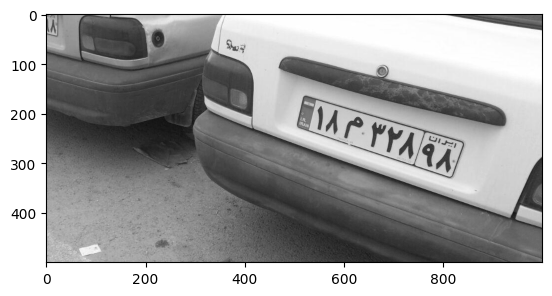

In [26]:
plt.imshow(train_images[0], cmap='gray')

In [27]:
train_labels[0]

[843, 506, 334, 165]

### 2.Preparing Validation dataset

In [28]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/car_img-validation.zip', 'r') as file:
    file.extractall('validation_dataset')

In [29]:
import os

validation_folder = 'validation_dataset/validation/'
image_files = [f for f in os.listdir(validation_folder) if f.endswith(('png', 'jpg', 'jpeg'))]

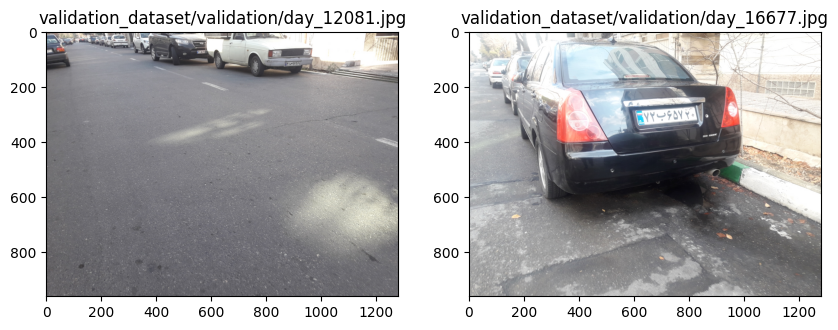

In [30]:
import os
from PIL import Image
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for i in range(2):
    path = os.path.join(validation_folder, image_files[i])
    img = plt.imread(path)

    plt.subplot(1, 2, i + 1)
    plt.imshow(img)
    plt.title(path)

plt.show()

In [32]:
len(image_files)

2120

### Separate images taken in day

In [33]:
image_files = [t for t in image_files if t.startswith('day')]
len(image_files)

1708

### Separate Validation Labels related to images in day

In [34]:
label_files = ['{}.xml'.format(t.split('.')[0]) for t in image_files]
len(label_files)

1708

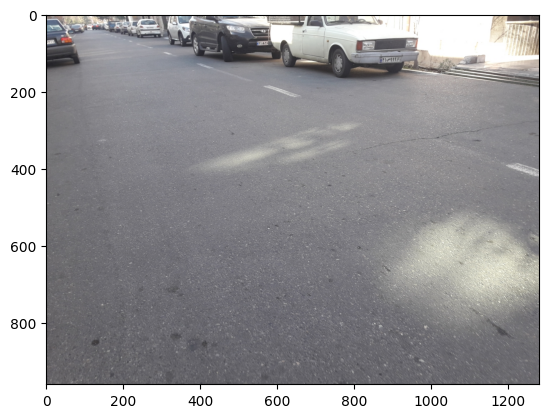

In [35]:
plt.imshow(plt.imread(validation_folder + image_files[0]))

In [36]:
extract_plate_numbers(os.path.join(validation_folder, label_files[0]))

[['4', '1', 'ص', '9', '9', '9', '4', '1']]

In [37]:
extract_plate_coordinates(os.path.join(validation_folder, label_files[0]))

[933, 860, 137, 101]

### Converting all xml content to plate coordinates

In [38]:
validation_labels = []

for i in range(len(label_files)):
    plate = extract_plate_coordinates(os.path.join(validation_folder, label_files[i]))
    validation_labels.append(plate)

### Loading images content and reshaping to (1280, 1280, 3)

In [39]:
validation_images = []

for i in range(len(image_files)):
    image = cv.imread(os.path.join(validation_folder, image_files[i]))
    image_gray = cv.cvtColor(image, cv.COLOR_RGB2GRAY)

    label = validation_labels[i]
    img, x_max, x_min, y_max, y_min = resize_image(image_gray, label)

    validation_images.append(img)
    validation_labels[i] = [x_max, x_min, y_max, y_min]

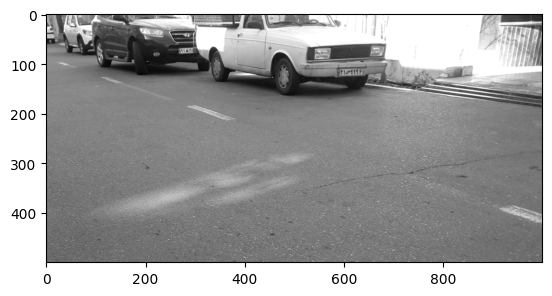

In [41]:
plt.imshow(validation_images[0], cmap='gray')

In [42]:
validation_labels[0]

[653, 580, 137, 101]

### Plot some train and validation images with their plate coordinates

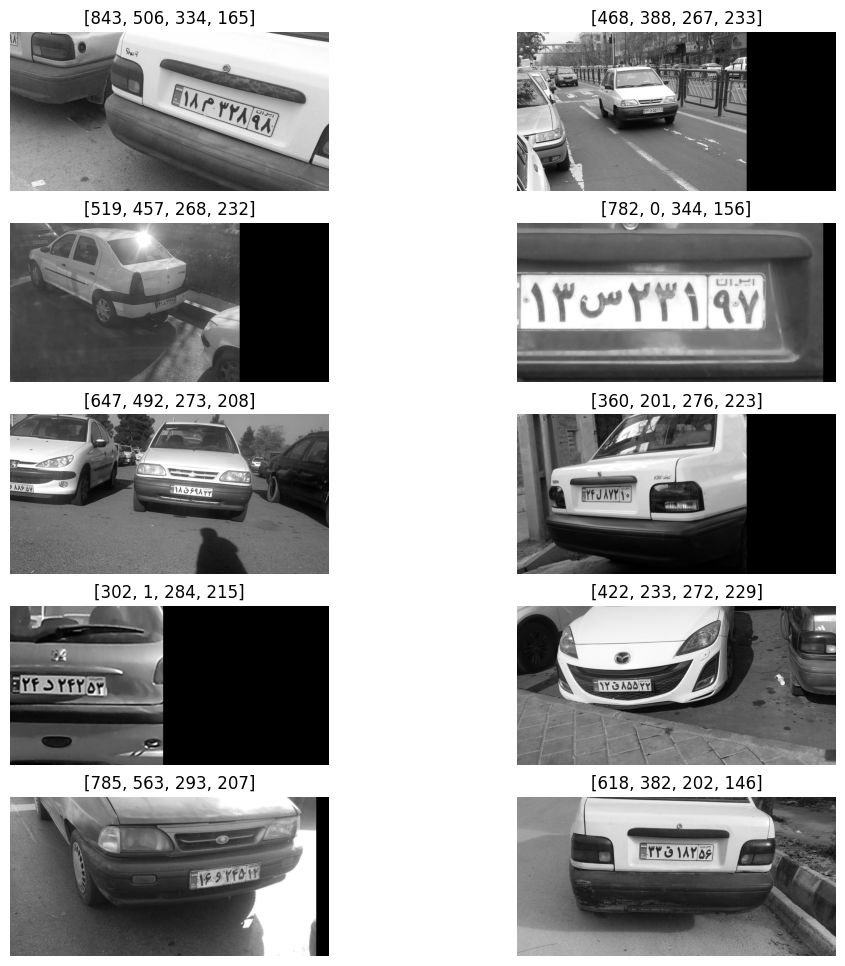

In [51]:
plt.figure(figsize=(12, 12))

for i in range(10):
    plt.subplot(5, 2, i + 1)
    plt.imshow(train_images[i], cmap='gray')
    plt.title(train_labels[i])
    plt.axis('off')

plt.show()

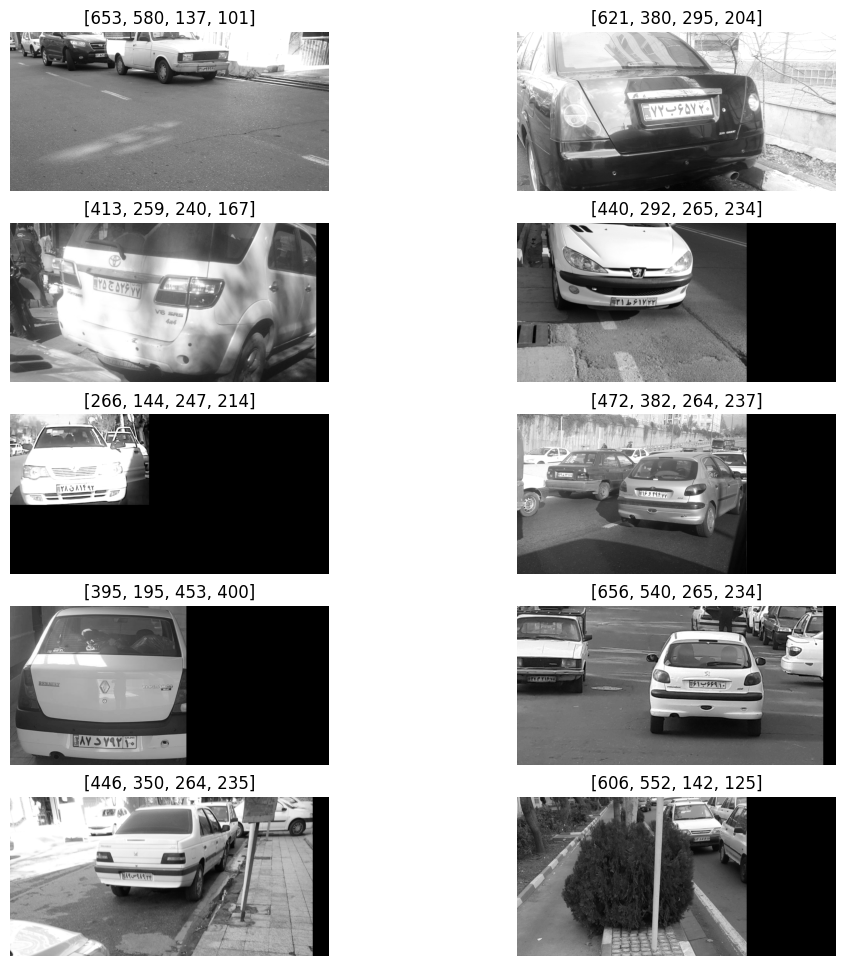

In [53]:
plt.figure(figsize=(12, 12))

for i in range(10):
    plt.subplot(5, 2, i + 1)
    plt.imshow(validation_images[i], cmap='gray')
    plt.title(validation_labels[i])
    plt.axis('off')

plt.show()

In [58]:
train_images = np.array(train_images)
validation_images = np.array(validation_images)

train_labels = np.array(train_labels)
validation_labels = np.array(validation_labels)

In [59]:
train_images.shape, validation_images.shape, train_labels.shape, validation_labels.shape

((3351, 500, 1000), (1708, 500, 1000), (3351, 4), (1708, 4))

### Creating model for training plate coordinates

In [67]:
from keras import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D


model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(2, 2), activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(2, 2), activation='relu'))
model.add(MaxPooling2D(2))

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)